# Combined Series Analysis

In [1]:
import os

import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
import h5py
from anytree import Node, RenderTree
import nexusformat.nexus as nx
import pickle

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import matplotlib.cm as cm
from mlxtend.plotting import scatterplotmatrix




from fault_management_uds.data.data_utilities import print_tree
from fault_management_uds.data.load_save_data import load_dataframe, save_dataframe, overwrite_dataset, save_filtered_data
from fault_management_uds.data.load_save_data import save_metadata, load_metadata, import_metadata
from fault_management_uds.plots import set_meaningful_xaxis_timestamps, get_segment_start_end_color


from fault_management_uds.config import PROJ_ROOT
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR
from fault_management_uds.config import rain_gauges, natural_structure_order, natural_sensor_order, series_order

2024-10-14 08:55:15.489 | INFO     | fault_management_uds.config:<module>:11 - PROJ_ROOT path is: /Users/arond.jacobsen/Documents/GitHub/fault_management_uds


In [2]:
np.random.seed(11)

#### Load subset

In [3]:
data_file_path = PROCESSED_DATA_DIR / 'Bellinge.h5'
f = print_tree(data_file_path)

root
├── dummy
└── processed
    ├── combined_data
    │   ├── cleaned
    │   │   ├── columns
    │   │   ├── data
    │   │   └── timestamps
    │   ├── interpolated
    │   │   ├── columns
    │   │   ├── data
    │   │   └── timestamps
    │   ├── is_error
    │   │   ├── columns
    │   │   ├── data
    │   │   └── timestamps
    │   ├── no_data
    │   │   ├── columns
    │   │   ├── data
    │   │   └── timestamps
    │   └── raw
    │       ├── columns
    │       ├── data
    │       └── timestamps
    └── single_series
        ├── 5425
        │   ├── columns
        │   ├── data
        │   └── timestamps
        ├── 5427
        │   ├── columns
        │   ├── data
        │   └── timestamps
        ├── G71F04R_Level1
        │   ├── columns
        │   ├── data
        │   └── timestamps
        ├── G71F04R_Level2
        │   ├── columns
        │   ├── data
        │   └── timestamps
        ├── G71F05R_LevelBasin
        │   ├── columns
        │   ├── data
        │   └

In [37]:
# load the timestamps
timestamps = f['processed']['combined_data']['raw']['timestamps'][:]
timestamps = pd.to_datetime(timestamps)
starttime = timestamps[0]
endtime = timestamps[-1]
print(f"Start time: {starttime} - End time: {endtime}")

Start time: 2010-01-01 00:00:00 - End time: 2021-08-19 00:00:00


In [38]:

raw_path = '/processed/combined_data/raw'
is_error_path = '/processed/combined_data/is_error'
no_data_path = '/processed/combined_data/no_data'

# starttime = "01-01-2019 00:00:00"
# endtime = "01-01-2020 00:00:00"

return_type = "df"

In [39]:
# load

raw, timestamps, columns, start_idx, end_idx, column_indices = load_dataframe(
    data_file_path, raw_path, 
    return_type=return_type, starttime=starttime, endtime=endtime
    )
    
is_error, timestamps, columns, start_idx, end_idx, column_indices = load_dataframe(
    data_file_path, is_error_path, 
    return_type=return_type, starttime=starttime, endtime=endtime
    )

no_data, timestamps, columns, start_idx, end_idx, column_indices = load_dataframe(
    data_file_path, no_data_path, 
    return_type=return_type, starttime=starttime, endtime=endtime
    )


# fill na with 0
raw = raw.fillna(0)
is_error = is_error.fillna(0)
no_data = no_data.fillna(0)

# readjust the order of the columns
raw = raw[series_order]
is_error = is_error[series_order]
no_data = no_data[series_order]

        Data loaded from group '/processed/combined_data/raw'
        Data loaded from group '/processed/combined_data/is_error'
        Data loaded from group '/processed/combined_data/no_data'


# Overview

In [40]:
indicator_metadata = {
    # Plotting order
    'No Data': {
        'color': 'linen',
        'value': 2
    },
    'Data': {
        'color': 'forestgreen',
        'value': 1
    },
    'Zero Valued': {
        'color': 'lightgreen',
        'value': 0
    },
    'Error': {
        'color': 'firebrick',
        'value': 3
    }
}

# create the index to color mapping
indicator_2_color = {v['value']: v['color'] for k, v in indicator_metadata.items()}
indicator_2_name = {v['value']: k for k, v in indicator_metadata.items()}
name_2_color = {k: v['color'] for k, v in indicator_metadata.items()}
color_2_name = {v['color']: k for k, v in indicator_metadata.items()}


In [41]:
def create_combined_I(raw, is_error, no_data):

    timestamps_df = pd.DataFrame(raw.index, columns=['time'])
    I = np.zeros_like(raw) # 0 where there is zero value data
    I[(raw > 0).values] = 1 # 1 where there is data
    I[(no_data > 0).values] = 2 # 2 where there is no data
    I[(is_error > 0).values] = 3 # 3 where there is an error

    return I, timestamps_df

In [42]:

I, timestamps_df = create_combined_I(raw, is_error, no_data)

#I = I.transpose()

series = list(raw.columns)

# for i, serie in enumerate(series):
#     print(series[i])
#     # check that the data is correct

#     # check that where I is 0, the raw data is also 0
#     assert np.all(raw[serie][I[i] == 0] == 0), f'Zero value data is not ok'
#     print(f'   Zero value data (ok): {np.all(raw[serie][I[i] == 0] == 0)}   |   {np.sum(I[i] == 0)}')

#     # check that where I is 1, the raw data is not 0
#     assert np.all(raw[serie][I[i] == 1] != 0), f'Data is not ok'
#     print(f'   Data (ok): {np.all(raw[serie][I[i] == 1] != 0)}   |   {np.sum(I[i] == 1)}')

#     # check that where I is 2, the no_data is 1
#     assert np.all(no_data[serie][I[i] == 2] == 1), f'No data is not ok'
#     print(f'   No data (ok): {np.all(no_data[serie][I[i] == 2] == 1)}   |   {np.sum(I[i] == 2)}')

#     # check that where I is 3, the is_error is 1
#     assert np.all(is_error[serie][I[i] == 3] == 1), f'Error is not ok'
#     print(f'   Error (ok): {np.all(is_error[serie][I[i] == 3] == 1)}   |   {np.sum(I[i] == 3)}')
    
#     print('-------------------')


In [43]:
# check that 
def evaluate_consistency(data, time_column):
    # Check for missing timestamps
    start_date = data[time_column].min()
    end_date = data[time_column].max()
    full_range = pd.date_range(start=start_date, end=end_date, freq='1min')
    missing_data = full_range.difference(data[time_column])
    print(f"Number of missing timestamps: {len(missing_data)} out of {len(full_range)}")    
    return missing_data

missing_data = evaluate_consistency(timestamps_df, 'time')
missing_data

Number of missing timestamps: 0 out of 6117121


DatetimeIndex([], dtype='datetime64[ns]', freq='min')

Test plot

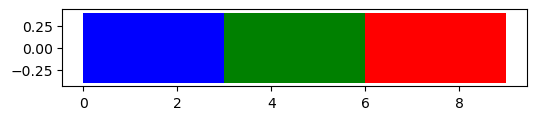

In [44]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(6, 1))#, dpi=300)

row = np.array([0,0,0,1,1,1,2,2,2])
colors = {0: 'blue', 1: 'green', 2: 'red', 3: 'black'}  
# Iterate over each row in the 2D array I to plot segments
# Find the start and end of each segment
segment_starts = np.flatnonzero(np.diff(row)) + 1  # segment start
segment_starts = np.insert(segment_starts, 0, 0)
segment_ends = np.append(segment_starts[1:], len(row)) 
# Plot segments in one go using vectorized operations
segments = np.column_stack((segment_starts, segment_ends - segment_starts))

# get the color for each starting segment
segment_color = np.vectorize(colors.get)(row[segment_starts])
# plot the segments
ax.broken_barh(segments, (0 - 0.4, 0.8), facecolors=segment_color)

plt.show()

Data availability

In [57]:
def visualize_combined_timeline(I, timestamps_df, series, indicator_2_color, name_2_color, figsize=(16, 4)):

    # Reshape I
    I = I.transpose()

    # Set up the figure and axes
    fig, ax = plt.subplots(figsize=figsize, dpi=400)

    bar_width = 0.8

    # Iterate over each row in the 2D array I to plot segments
    for i, row in enumerate(I):
        segment_starts, segment_ends, segment_color = get_segment_start_end_color(row, indicator_2_color)
        segments = np.column_stack((segment_starts, segment_ends - segment_starts))
        # plot the segments
        #ax.broken_barh(segments, (i - bar_width/2, bar_width), facecolors=segment_color)
        ax.broken_barh(segments, (i - 0.4, 0.6), facecolors=segment_color)


    # Set the legend
    legend_elements = [Patch(facecolor=color, label=name) for name, color in name_2_color.items()]
    # Add legend: at the bottom of the plot, centered horizontally and stretched to the width of the plot
    ax.legend(handles=legend_elements, loc='lower center', ncol=len(legend_elements), frameon=False, bbox_to_anchor=(0.5, -0.17), fontsize=12)

    #ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))




    # Set the y-ticks and labels
    ax.set_yticks(np.arange(I.shape[0]))
    ax.set_yticklabels(series)
    ax.invert_yaxis()

    # Set the x-axis
    ax = set_meaningful_xaxis_timestamps(ax, timestamps_df)

    # # add vertical lines for the years
    # for year in year_start_idx:
    #     ax.axvline(x=year, color='lightgray', linestyle='--', linewidth=0.5)
    # remove outer frame
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False); ax.spines['left'].set_visible(False); ax.spines['bottom'].set_visible(False)
    # Show the plot
    plt.tight_layout()
    plt.show()

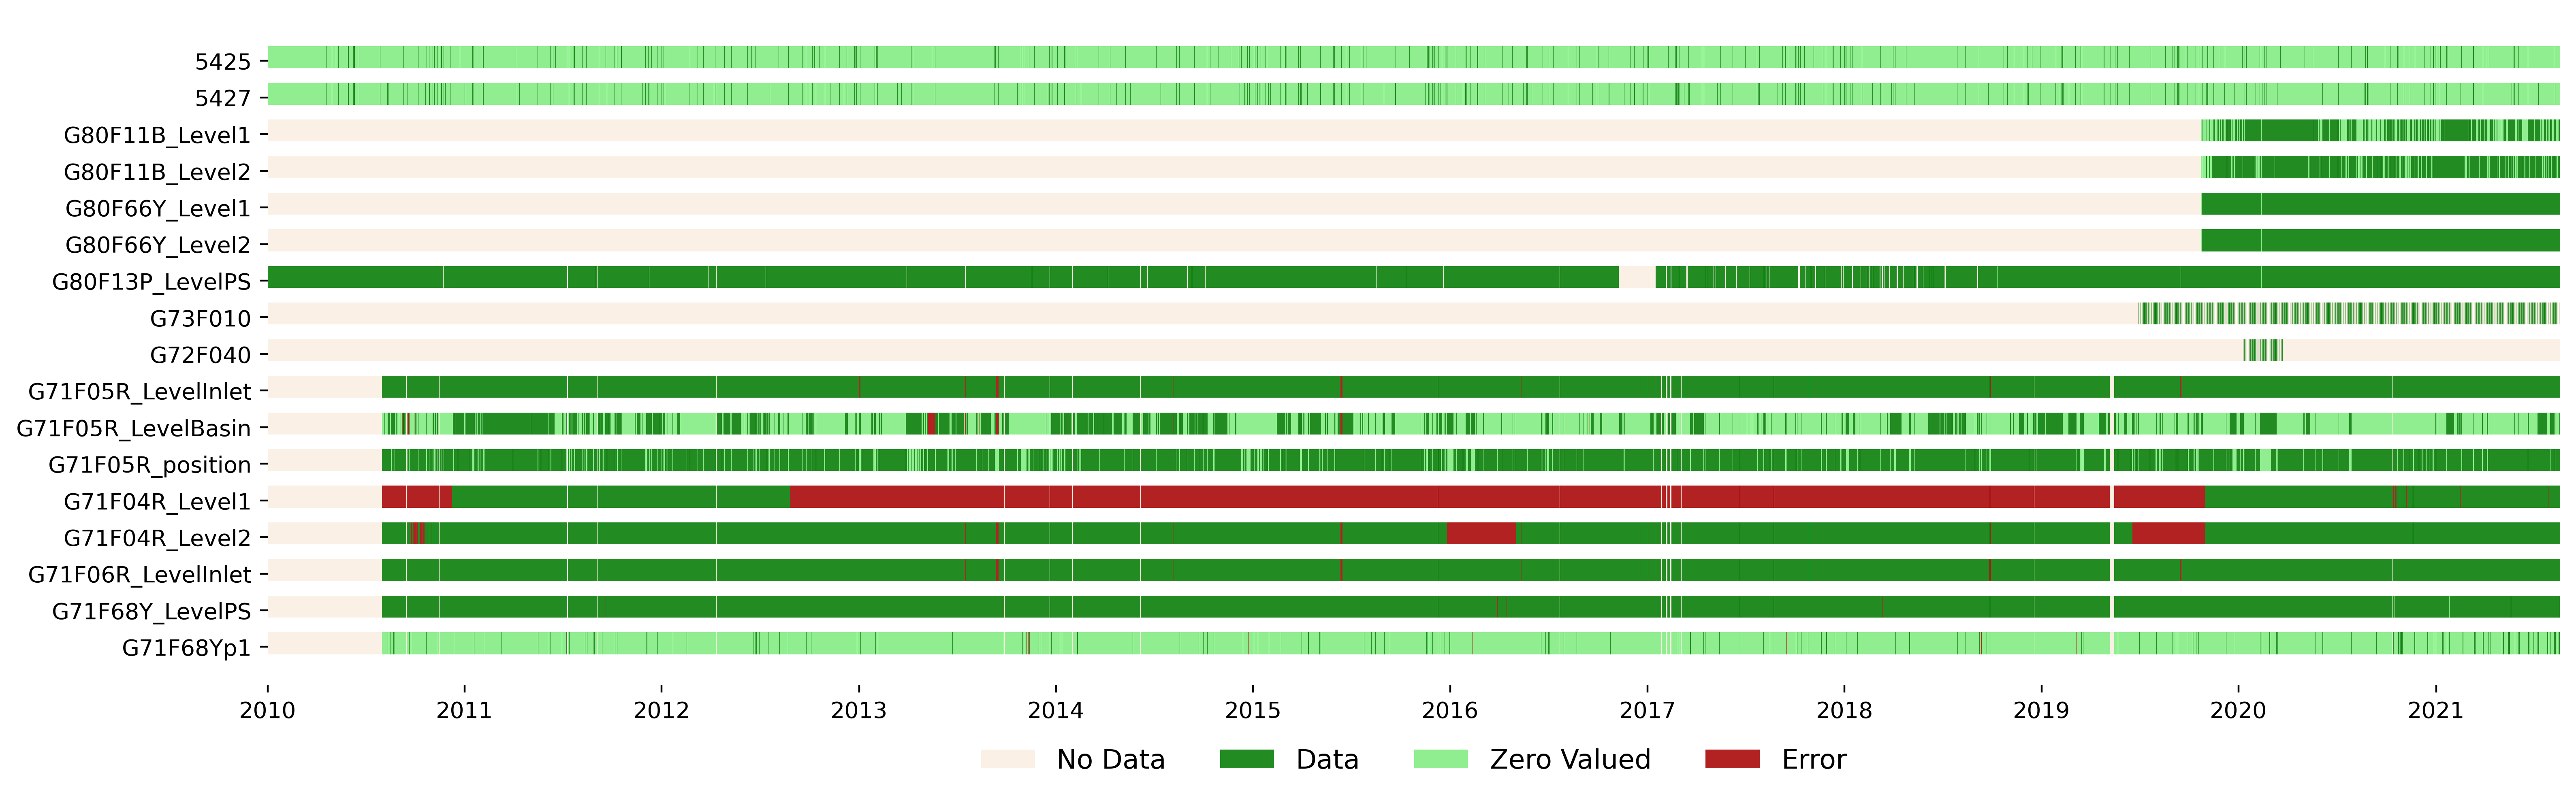

In [58]:
visualize_combined_timeline(I, timestamps_df, series, indicator_2_color, name_2_color, figsize=(16, 5))

- Rain is generally zero

## Biases

In [34]:
# zero value
I_df = pd.DataFrame(I, columns=series)
# aggregate the data, group by the unique values of I and count the number of occurences
I_agg = {}
for serie in series:
    I_agg[serie] = I_df[serie].value_counts().sort_index()
I_agg_df = pd.DataFrame(I_agg).fillna(0)#.transpose()

I_agg_df

,5425,5427,G80F11B_Level1,G80F11B_Level2,G80F66Y_Level1,G80F66Y_Level2,G80F13P_LevelPS,G73F010,G72F040,G71F05R_LevelInlet,G71F05R_LevelBasin,G71F05R_position,G71F04R_Level1,G71F04R_Level2,G71F06R_LevelInlet,G71F68Y_LevelPS,G71F68Yp1
0.0,991005.0,985437.0,217650.0,110231.0,1614,1755,1629.0,1107,0.0,1,763409,126600.0,1,1,1,1909,997881
1.0,61636.0,67204.0,409455.0,516874.0,625461,625317,1050965.0,397771,53740.0,1034666,274265,912403.0,611464,844410,1034694,1036527,40138
2.0,0.0,0.0,425536.0,425536.0,425532,425532,0.0,653760,998798.0,13638,13638,13638.0,13318,13318,13638,14062,14099
3.0,0.0,0.0,0.0,0.0,34,37,47.0,3,103.0,4336,1329,0.0,427858,194912,4308,143,523


In [35]:
C_agg_df = I_agg_df.sum(axis=1)  
C_agg_df  

0.0    4200231.0
1.0    9596990.0
2.0    3464043.0
3.0     633633.0
dtype: float64

In [60]:
C_agg_df = I_agg_df.sum(axis=1)  

C_agg_df = C_agg_df.to_frame().reset_index().rename(columns={'index': 'Indicator', 0: 'Count'})
C_agg_df['Name'] = C_agg_df['Indicator'].map(indicator_2_name)
# add the missing indicators
for indicator, name in indicator_2_name.items():
    if indicator not in C_agg_df['Indicator'].values:
        C_agg_df = pd.concat([C_agg_df, pd.DataFrame({'Name': [name], 'Indicator': [indicator], 'Count': [0]})])
C_agg_df = C_agg_df.fillna(0)
# sort by indicator value
C_agg_df = C_agg_df.sort_values(by='Indicator')
# reset the index
C_agg_df = C_agg_df.reset_index(drop=True)
C_agg_df = C_agg_df.loc[list(indicator_2_name.keys())]
C_agg_df

,Indicator,Count,Name
2,2.0,3464043.0,No Data
1,1.0,9596990.0,Data
0,0.0,4200231.0,Zero Valued
3,3.0,633633.0,Error


In [61]:


fig = px.bar(C_agg_df, x='Name', y='Count', color='Name', 
    color_discrete_map=name_2_color,
    labels={'Name': ''},
    # add count on top of the bars
    text='Count',
    height=300,
    width=800,  
    )

# update the hover
fig.update_traces(hovertemplate='Count: %{y}<extra></extra>')
fig.show()

In [68]:
C_agg_df

,Indicator,Count,Name
2,2.0,3464043.0,No Data
1,1.0,9596990.0,Data
0,0.0,4200231.0,Zero Valued
3,3.0,633633.0,Error


In [69]:
sub_agg_df = C_agg_df.copy()
# combine Indicator 3 with 2, and Indicator 0 with 1
sub_agg_df.loc[2, 'Count'] += sub_agg_df.loc[3, 'Count']
sub_agg_df.loc[1, 'Count'] += sub_agg_df.loc[0, 'Count']
sub_agg_df = sub_agg_df.drop([0, 3])
sub_agg_df = sub_agg_df.reset_index(drop=True)
sub_agg_df

,Indicator,Count,Name
0,2.0,4097676.0,No Data
1,1.0,13797221.0,Data


In [70]:
fig = px.bar(sub_agg_df, x='Name', y='Count', color='Name', 
    color_discrete_map=name_2_color,
    labels={'Name': ''},
    # add count on top of the bars
    text='Count',
    height=300,
    width=800,  
    )

# update the hover
fig.update_traces(hovertemplate='Count: %{y}<extra></extra>')
fig.show()

In [74]:
sub_agg_df = C_agg_df.copy()
# combine Indicator 3 with 2, and Indicator 0 with 1
sub_agg_df.loc[0, 'Count'] += sub_agg_df.loc[3, 'Count']
sub_agg_df.loc[0, 'Count'] += sub_agg_df.loc[2, 'Count']
sub_agg_df = sub_agg_df.drop([2, 3])
sub_agg_df = sub_agg_df.reset_index(drop=True)
sub_agg_df

,Indicator,Count,Name
0,1.0,9596990.0,Data
1,0.0,8297907.0,Zero Valued


In [75]:
fig = px.bar(sub_agg_df, x='Name', y='Count', color='Name', 
    color_discrete_map=name_2_color,
    labels={'Name': ''},
    # add count on top of the bars
    text='Count',
    height=300,
    width=800,  
    )

# update the hover
fig.update_traces(hovertemplate='Count: %{y}<extra></extra>')
fig.show()

In [53]:

# stacked plotly bar chart
fig = go.Figure()
data = []
#for name in list(indicator_metadata.keys())[::-1]:
for name in indicator_metadata:
    i = indicator_metadata[name]['value']
    row = I_agg_df.loc[i].values
    data.append(go.Bar(
        x=I_agg_df.columns,
        y=row,
        name=indicator_2_name[i],
        marker_color=indicator_2_color[i],
        # add hoverinfo, percentage of the total
        #hoverinfo='y', 
        hovertemplate='%{y:.2f}',
        ))

fig.add_traces(data)

fig.update_layout(
    #barmode='stack', 
    xaxis_tickangle=-45,
    height=400, 
    width=1000,
    barnorm='percent',
    legend=dict(traceorder='normal'),  # Reverse the order of the legend items

)
fig.show()



In [51]:

# stacked plotly bar chart
fig = go.Figure()
data = []
#for name in list(indicator_metadata.keys())[::-1]:
for name in indicator_metadata:
    i = indicator_metadata[name]['value']
    row = I_agg_df.loc[i].values
    data.append(go.Bar(
        x=I_agg_df.columns,
        y=row,
        name=indicator_2_name[i],
        marker_color=indicator_2_color[i],
        # add hoverinfo, percentage of the total
        hoverinfo='y', 
        hovertemplate='%{y:.2f}%',
        ))

fig.add_traces(data)

fig.update_layout(
    barmode='stack', 
    xaxis_tickangle=-45,
    height=400, 
    width=1000,
    barnorm='percent',
    legend=dict(traceorder='normal'),  # Reverse the order of the legend items

)
fig.show()



- Many different data biases across the series
- how to effectively handle during modelling?

In [65]:
I_agg_df

,5425,5427,G80F11B_Level1,G80F11B_Level2,G80F66Y_Level1,G80F66Y_Level2,G80F13P_LevelPS,G73F010,G72F040,G71F05R_LevelInlet,G71F05R_LevelBasin,G71F05R_position,G71F04R_Level1,G71F04R_Level2,G71F06R_LevelInlet,G71F68Y_LevelPS,G71F68Yp1
0.0,991005.0,985437.0,217650.0,110231.0,1614,1755,1629.0,1107,0.0,1,763409,126600.0,1,1,1,1909,997881
1.0,61636.0,67204.0,409455.0,516874.0,625461,625317,1050965.0,397771,53740.0,1034666,274265,912403.0,611464,844410,1034694,1036527,40138
2.0,0.0,0.0,425536.0,425536.0,425532,425532,0.0,653760,998798.0,13638,13638,13638.0,13318,13318,13638,14062,14099
3.0,0.0,0.0,0.0,0.0,34,37,47.0,3,103.0,4336,1329,0.0,427858,194912,4308,143,523


In [76]:
I_agg_df

,5425,5427,G80F11B_Level1,G80F11B_Level2,G80F66Y_Level1,G80F66Y_Level2,G80F13P_LevelPS,G73F010,G72F040,G71F05R_LevelInlet,G71F05R_LevelBasin,G71F05R_position,G71F04R_Level1,G71F04R_Level2,G71F06R_LevelInlet,G71F68Y_LevelPS,G71F68Yp1
0.0,991005.0,985437.0,217650.0,110231.0,1614,1755,1629.0,1107,0.0,1,763409,126600.0,1,1,1,1909,997881
1.0,61636.0,67204.0,409455.0,516874.0,625461,625317,1050965.0,397771,53740.0,1034666,274265,912403.0,611464,844410,1034694,1036527,40138
2.0,0.0,0.0,425536.0,425536.0,425532,425532,0.0,653760,998798.0,13638,13638,13638.0,13318,13318,13638,14062,14099
3.0,0.0,0.0,0.0,0.0,34,37,47.0,3,103.0,4336,1329,0.0,427858,194912,4308,143,523


In [80]:
sub_agg_df = I_agg_df.copy()
for col in sub_agg_df.columns:
    # combine Indicator 3 with 2, and Indicator 0 with 1
    sub_agg_df.loc[2, col] += sub_agg_df.loc[3, col]
    sub_agg_df.loc[1, col] += sub_agg_df.loc[0, col]
sub_agg_df = sub_agg_df.drop([0, 3])
#sub_agg_df = sub_agg_df.reset_index(drop=True)
sub_agg_df

,5425,5427,G80F11B_Level1,G80F11B_Level2,G80F66Y_Level1,G80F66Y_Level2,G80F13P_LevelPS,G73F010,G72F040,G71F05R_LevelInlet,G71F05R_LevelBasin,G71F05R_position,G71F04R_Level1,G71F04R_Level2,G71F06R_LevelInlet,G71F68Y_LevelPS,G71F68Yp1
1.0,1052641.0,1052641.0,627105.0,627105.0,627075,627072,1052594.0,398878,53740.0,1034667,1037674,1039003.0,611465,844411,1034695,1038436,1038019
2.0,0.0,0.0,425536.0,425536.0,425566,425569,47.0,653763,998901.0,17974,14967,13638.0,441176,208230,17946,14205,14622


In [81]:

# stacked plotly bar chart
fig = go.Figure()
data = []
#for name in list(indicator_metadata.keys())[::-1]:
for i, row in sub_agg_df.iterrows():
    # i = indicator_metadata[name]['value']
    # row = sub_agg_df.loc[i].values
    data.append(go.Bar(
        x=sub_agg_df.columns,
        y=row,
        name=indicator_2_name[i],
        marker_color=indicator_2_color[i],
        # add hoverinfo, percentage of the total
        hoverinfo='y', 
        hovertemplate='%{y:.2f}%',
        ))

fig.add_traces(data)

fig.update_layout(
    barmode='stack', 
    xaxis_tickangle=-45,
    height=400, 
    width=1000,
    barnorm='percent',
    legend=dict(traceorder='normal'),  # Reverse the order of the legend items

)
fig.show()



In [82]:
sub_agg_df = I_agg_df.copy()
for col in sub_agg_df.columns:
    # combine Indicator 3 with 2, and Indicator 0 with 1
    sub_agg_df.loc[0, col] += sub_agg_df.loc[2, col]
    sub_agg_df.loc[0, col] += sub_agg_df.loc[3, col]
sub_agg_df = sub_agg_df.drop([2, 3])
#sub_agg_df = sub_agg_df.reset_index(drop=True)
sub_agg_df

,5425,5427,G80F11B_Level1,G80F11B_Level2,G80F66Y_Level1,G80F66Y_Level2,G80F13P_LevelPS,G73F010,G72F040,G71F05R_LevelInlet,G71F05R_LevelBasin,G71F05R_position,G71F04R_Level1,G71F04R_Level2,G71F06R_LevelInlet,G71F68Y_LevelPS,G71F68Yp1
0.0,991005.0,985437.0,643186.0,535767.0,427180,427324,1676.0,654870,998901.0,17975,778376,140238.0,441177,208231,17947,16114,1012503
1.0,61636.0,67204.0,409455.0,516874.0,625461,625317,1050965.0,397771,53740.0,1034666,274265,912403.0,611464,844410,1034694,1036527,40138


In [83]:

# stacked plotly bar chart
fig = go.Figure()
data = []
#for name in list(indicator_metadata.keys())[::-1]:
for i, row in sub_agg_df.iterrows():
    # i = indicator_metadata[name]['value']
    # row = sub_agg_df.loc[i].values
    data.append(go.Bar(
        x=sub_agg_df.columns,
        y=row,
        name=indicator_2_name[i],
        marker_color=indicator_2_color[i],
        # add hoverinfo, percentage of the total
        hoverinfo='y', 
        hovertemplate='%{y:.2f}%',
        ))

fig.add_traces(data)

fig.update_layout(
    barmode='stack', 
    xaxis_tickangle=-45,
    height=400, 
    width=1000,
    barnorm='percent',
    legend=dict(traceorder='normal'),  # Reverse the order of the legend items

)
fig.show()



### TODO:
- can do this, where the `error` is expanded

## Distributions

#### Scatter and histogram

In [106]:
# randomly sample 30% of the data
sub_raw = raw.sample(frac=0.15, random_state=11)

In [107]:
scatterplotmatrix(sub_raw.values, figsize=(50, 40), names=sub_raw.columns, alpha=0.5)
# save the figure
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'scatterplot_matrix.png', dpi=300)
plt.close()

In [122]:
raw.head(2)

,5425,5427,G80F11B_Level1,G80F11B_Level2,G80F66Y_Level1,G80F66Y_Level2,G80F13P_LevelPS,G73F010,G72F040,G71F05R_LevelInlet,G71F05R_LevelBasin,G71F05R_position,G71F04R_Level1,G71F04R_Level2,G71F06R_LevelInlet,G71F68Y_LevelPS,G71F68Yp1
time,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.91,0.0,0.0,0.244,0.0,0.594,0.0,0.049,0.068,0.071,0.0
2019-01-01 00:01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.0,0.0,0.246,0.0,0.593,0.0,0.048,0.068,0.071,0.0


In [137]:
# Ensure that the index of 'raw' is a DatetimeIndex
raw.index = pd.to_datetime(raw.index)

# Define the time range for February 2021
starttime = "2020-02-01 00:00:00"
endtime = "2020-03-01 00:00:00"

# Subsample the data for February 2021
sub_raw = raw.loc[starttime:endtime]
sub_is_error = is_error.loc[starttime:endtime]  
sub_no_data = no_data.loc[starttime:endtime]

# Subsample the corresponding timestamps
sub_timestamps = timestamps_df.loc[starttime:endtime]

sub_I, sub_timestamps_df = create_combined_I(sub_raw, sub_is_error, sub_no_data)

print(sub_raw.shape)

(41761, 17)


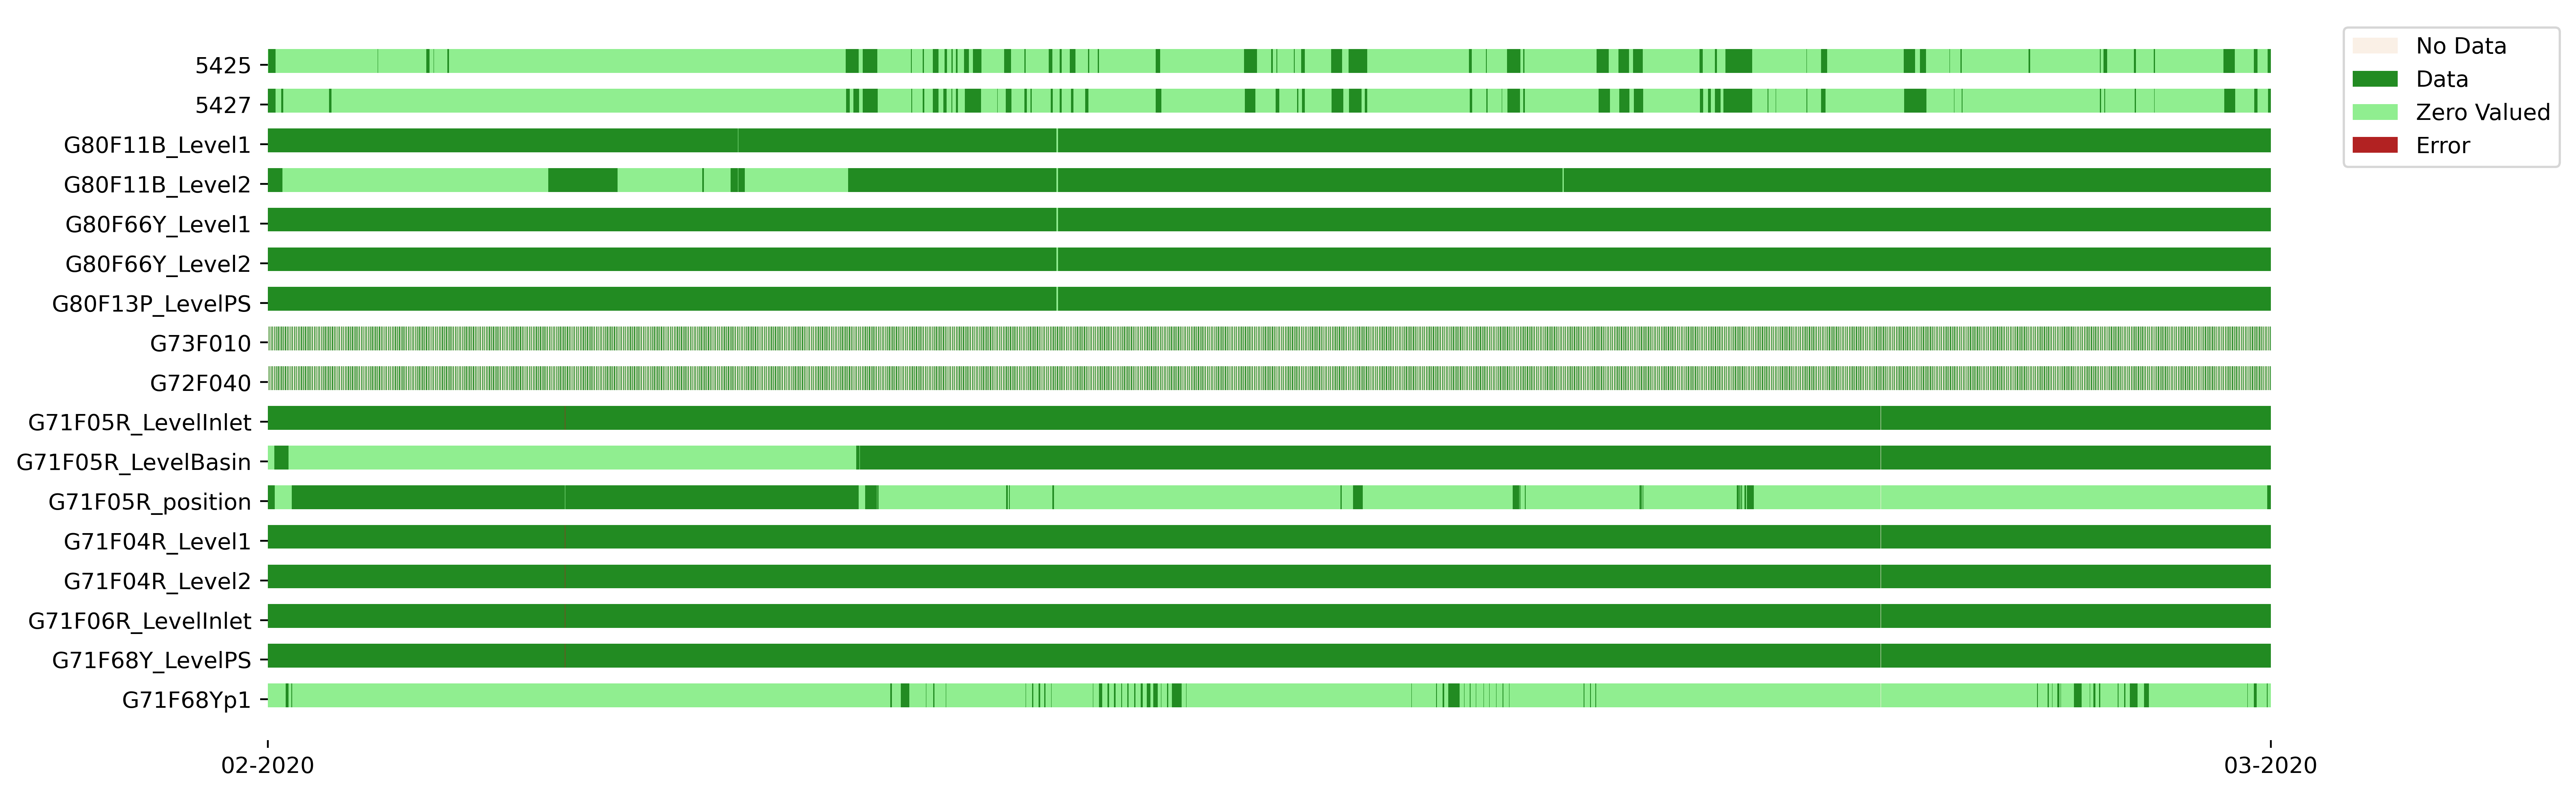

In [139]:
# plot the timeline
visualize_combined_timeline(sub_I, sub_timestamps_df, series, indicator_2_color, name_2_color, figsize=(16, 5))

In [140]:
scatterplotmatrix(sub_raw.values, figsize=(50, 40), names=sub_raw.columns, alpha=0.5)
# save the figure
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'scatterplot_matrix_feb.png', dpi=300)
plt.close()

#### Boxplot

In [143]:
raw_non_zero = raw[raw > 0]

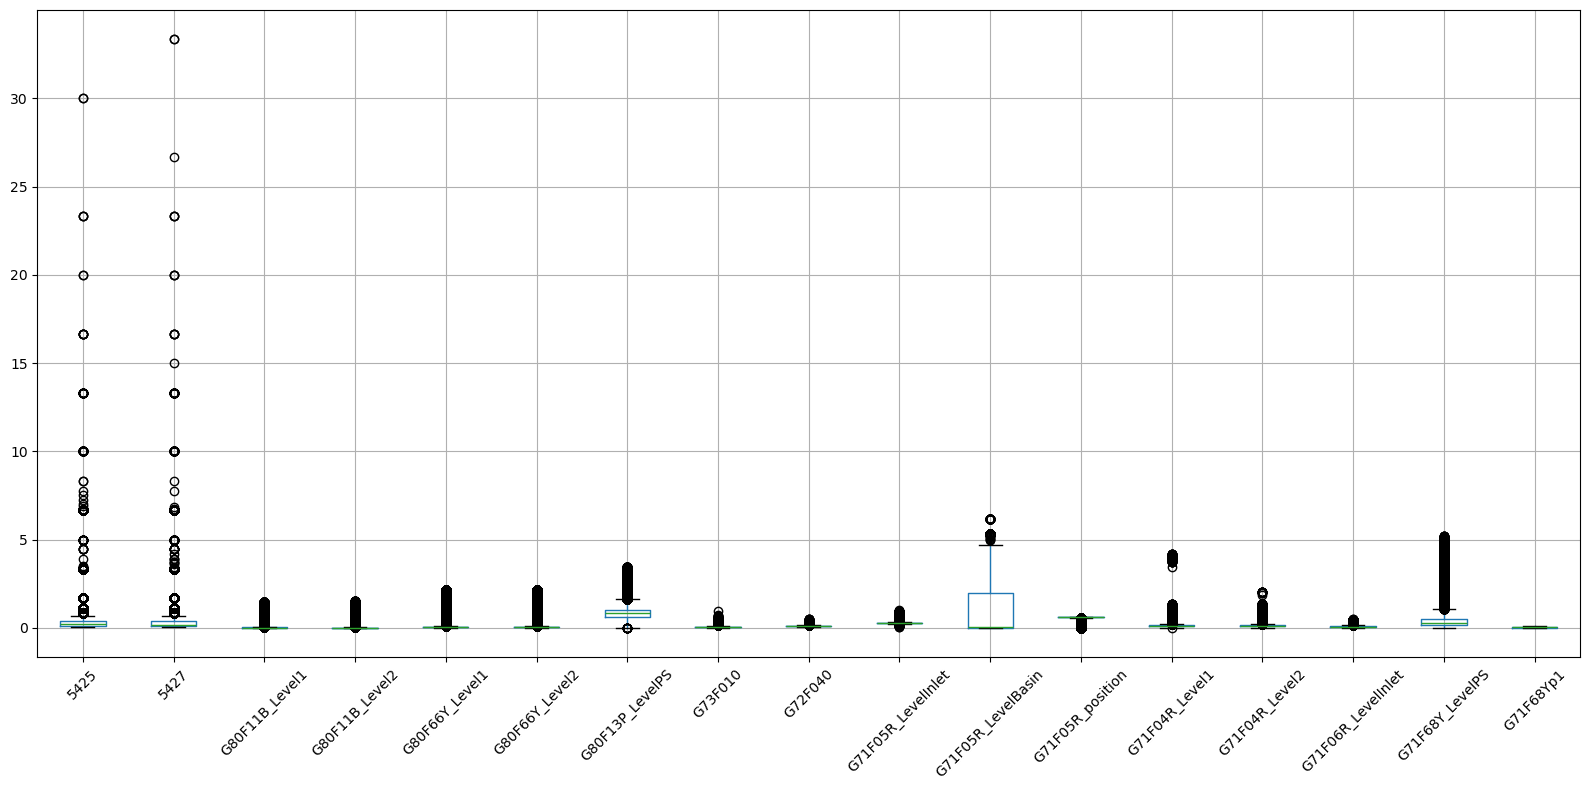

In [144]:
# make a boxplot for each column
fig, ax = plt.subplots(figsize=(16, 8))

raw_non_zero.boxplot(ax=ax, rot=45)
plt.tight_layout()
plt.show()